In [ ]:
from utils import load_tweets, process_tweet
import numpy as np
import json
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [2]:
positive_tweets, negative_tweets = load_tweets()

In [3]:
X_train = positive_tweets[:4000] + negative_tweets[:4000]
Y_train = np.append(np.ones((4000, 1)), np.zeros((4000,1)))

X_val = positive_tweets[4000:] + negative_tweets[4000:]
Y_val = np.append(np.ones((1000, 1)), np.zeros((1000,1)))
print(len(X_train), Y_train.shape, len(X_val), Y_val.shape)

8000 (8000,) 2000 (2000,)


In [4]:
vocabulary = {'_pad_': 0, '_unk_': 1}
max_length = 0

for tweet in X_train:
    processed_tweet = process_tweet(tweet)
    max_length = max(max_length, len(processed_tweet))
    for word in processed_tweet:
        if word not in vocabulary:
            vocabulary[word] = len(vocabulary)

print('Vocabulary size = ', len(vocabulary))
print('max tweet length = ', max_length)


Vocabulary size =  9087
max tweet length =  51


In [5]:
with open('vocabulary.json', 'w') as json_file:
    json.dump(vocabulary, json_file)

In [6]:
def tweet_to_tensor(X):
    X_final = []
    max_length = 51
    for tweet in X:
        processed_tweet = process_tweet(tweet)
        processed_tensor = []
        
        for word in processed_tweet:
            if word in vocabulary:
                processed_tensor.append(vocabulary[word])
            else:
                processed_tensor.append(vocabulary['_unk_'])
        
        padding_length = max_length - len(processed_tensor)
        processed_tensor = processed_tensor + [0]*padding_length
        X_final.append(processed_tensor)
    
    X_final = torch.tensor(X_final)
    
    return X_final
        

In [7]:
X_train = tweet_to_tensor(X_train)
Y_train = torch.tensor(Y_train)
Y_train = Y_train.view(X_train.shape[0], -1)


X_val = tweet_to_tensor(X_val)
Y_val = torch.tensor(Y_val)
Y_val = Y_val.view(X_val.shape[0], -1)

print('X_train shape = ', X_train.shape, ', Y_train shape = ', Y_train.shape)
print('X_val shape = ', X_val.shape, ', Y_val shape = ', Y_val.shape)

X_train shape =  torch.Size([8000, 51]) , Y_train shape =  torch.Size([8000, 1])
X_val shape =  torch.Size([2000, 51]) , Y_val shape =  torch.Size([2000, 1])


In [46]:
# pytorch code

class SAM(nn.Module):
    def __init__(self, vocab_dimension, n_hidden, vocab_length):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_length, vocab_dimension)
        self.layer1 = nn.Linear(vocab_dimension, n_hidden)
        self.layer2 = nn.Linear(n_hidden, 1)
    
    def forward(self, x):
        x = self.embedding(x)
        x = torch.mean(x, dim=1)
        x = torch.relu(self.layer1(x))
        logits = self.layer2(x)
        
        return logits

In [773]:
input_size = X_train.shape[1]
vocab_length = len(vocabulary)
vocab_dimension = 10
n_hidden = 5

model = SAM(vocab_dimension, n_hidden, vocab_length)
print(model)

SAM(
  (embedding): Embedding(9087, 10)
  (layer1): Linear(in_features=10, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)


In [774]:
def model_train(model, X_train, Y_train):
    
    optimizer = optim.Adam(model.parameters(), lr = 0.01)
    
    iterations = 40001
    batch_size = 32
    model.train()
    for iteration in range(iterations):    
        ix = torch.randint(0, X_train.shape[0], (batch_size,))
        X = X_train[ix]
        
        logits =model.forward(X)
        loss = F.binary_cross_entropy_with_logits(logits, Y_train[ix].float())
        
        optimizer.zero_grad()
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        
        
        if iteration % 10000 == 0:
            print(f'loss at iteration {iteration} = {loss.item()}')
    
    return loss
    

In [775]:
loss= model_train(model, X_train, Y_train)

loss at iteration 0 = 0.6975799798965454
loss at iteration 10000 = 1.7750560800777748e-05
loss at iteration 20000 = 1.9792025341303088e-05
loss at iteration 30000 = 7.55898654460907e-05
loss at iteration 40000 = 0.0


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      4000
         1.0       1.00      1.00      1.00      4000

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000



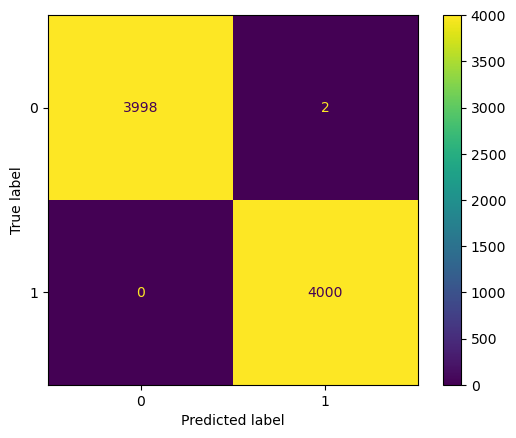

train loss = 0.0010158602487418031, train accuracy = 99.9749984741211%


In [776]:
@torch.no_grad()

def evaluate(split):
    x, y = {'train': (X_train,Y_train),
            'val': (X_val, Y_val)}[split]
    
    
    logits = model.forward(x)
    loss = F.binary_cross_entropy_with_logits(logits, y)
    preds = (torch.sigmoid(logits) > 0.5).float()
    accuracy = (preds == y).float().mean()*100
    
    print(classification_report(y, preds))
    cm = confusion_matrix(y, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    
    print(f'{split} loss = {loss}, {split} accuracy = {accuracy}%')

evaluate('train')


              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1000
         1.0       0.99      0.99      0.99      1000

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



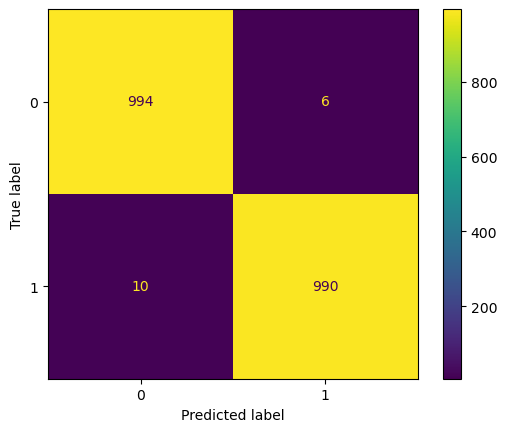

val loss = 0.04253823671879531, val accuracy = 99.19999694824219%


In [777]:
evaluate('val')

In [801]:
model.eval()
test_sentence = " I had a terrible day today and bad things happened"
tensor = tweet_to_tensor([test_sentence])
with torch.no_grad():
    logits = model(tensor)
    prediction = (torch.sigmoid(logits) > 0.5).int().squeeze()
    if prediction.item() == 1:
        print('Positive :)')
    else:
        print('Negative :(')

Negative :(


In [802]:
torch.save(model, 'sentiment_model_full.pth')

In [779]:
embeddings = list(model.parameters())[0]

In [780]:
embeddings.shape

torch.Size([9087, 10])

In [781]:
from sklearn.decomposition import PCA #Import PCA from scikit-learn
pca = PCA(n_components=2) #PCA with two dimensions

with torch.no_grad():
    emb_2dim = pca.fit_transform(embeddings) #Dimensionality reduction of the word embeddings

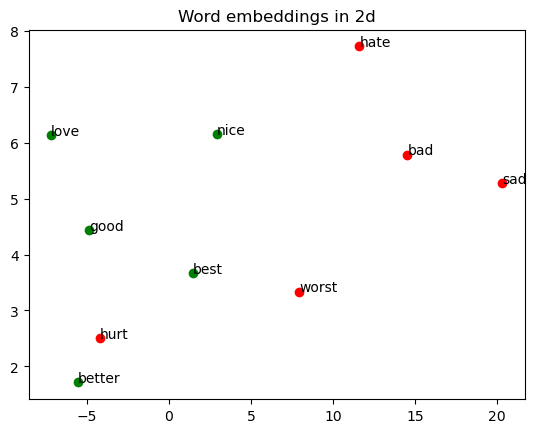

In [798]:
%matplotlib inline
import matplotlib.pyplot as plt

#Selection of negative and positive words
neg_words = ['worst', 'bad', 'hurt', 'sad', 'hate']
pos_words = ['best', 'good', 'nice', 'better', 'love']

#Index of each selected word
neg_n = [vocabulary[w] for w in neg_words]
pos_n = [vocabulary[w] for w in pos_words]

plt.figure()

#Scatter plot for negative words
plt.scatter(emb_2dim[neg_n][:,0],emb_2dim[neg_n][:,1], color = 'r')
for i, txt in enumerate(neg_words): 
    plt.annotate(txt, (emb_2dim[neg_n][i,0],emb_2dim[neg_n][i,1]))

#Scatter plot for positive words
plt.scatter(emb_2dim[pos_n][:,0],emb_2dim[pos_n][:,1], color = 'g')
for i, txt in enumerate(pos_words): 
    plt.annotate(txt,(emb_2dim[pos_n][i,0],emb_2dim[pos_n][i,1]))

plt.title('Word embeddings in 2d')

plt.show()